## Creating a Plot that Shows Radar-Derived Rainfall and Compares it to Rain Gauge Data

This code takes .csv files of rain gauge data and radar-estimated hourly precipitation rates and plots them.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pylab import *
import pyart, boto3, tempfile, os, shutil, datetime, matplotlib
import numpy as np
import pandas as pd
import pylab as pl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import animation
import netCDF4
from datetime import datetime


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Read in the files. "df" needed to be appended because the two days were in separate .csv files. "df" represents the gauge files through the entire code, and "hp" represents the radar-derived hourly precipitation.

In [2]:
# Read in the files.
hp = pd.read_csv("/home/amedendorp/Downloads/WaterYear2013_hourlyprecip.csv", skiprows=0,
                 na_values = ['no info', '.'])

# These .csv files are for two separate days, so they need to be appended together.
df = pd.read_csv("KLOT_20130417_RainAmounts_at_CookCountyGauges.csv")
df2 = pd.read_csv("KLOT_20130418_RainAmounts_at_CookCountyGauges.csv")

df = df.append(df2)

dates = [pd.Timestamp('2013-04-17'),
         pd.Timestamp('2013-04-18')]
ts = pd.Series(np.random.randn(2), dates)
type(ts.index)

pandas.core.indexes.datetimes.DatetimeIndex

renaming the DatetimeIndexes:

In [3]:
df_new = df
hp_new = hp

In [4]:
df_new.index = pd.to_datetime(df['Datetime'])
hp_new.index = pd.to_datetime(hp['Date/Time'])

Creating another new index, dropping the unnecessary columns:

In [5]:
df_new = df_new.drop(labels=['Datetime'], axis=1)
hp_new = hp_new.drop(labels=['Date/Time'], axis=1)

In [6]:
df_new.index = pd.to_datetime(df_new.index)
hp_new.index = pd.to_datetime(hp_new.index)

Converting both of the indexes to floats, since the current items inside the indexes are strings and cannot be processed that way:

In [7]:
df_float = df_new.convert_objects(convert_numeric=True)
hp_float = hp_new.convert_objects(convert_numeric=True)

Resample the rain gauge indexes while taking hourly sums (since the rain rate data is already in hour increments), and then convert mm into inches.

In [8]:
df_mean = df_float.resample('1H', how='sum')
df_new = df_mean/24.5

This next block of code fixes the five-hour data "shift" of the rain gauge data due to it being in UTC, not local time like the radar-estimated rain rate data is. Now both of the datasets are on the same time scale, so they can be plotted together.

In [9]:
df_new.index = df_new.index + pd.DateOffset(hours=-5)

Creating arrays based on the DatetimeIndex:

In [10]:
lines_epoch_array = np.asanyarray(df_new.index)
lines_time_array = pd.to_datetime(lines_epoch_array,  unit='s')
lines_time_array

hp_lines_epoch_array = np.asanyarray(hp.index)
hp_lines_time_array = pd.to_datetime(hp_lines_epoch_array,  unit='s')
hp_lines_time_array

DatetimeIndex(['2012-10-01 01:00:00', '2012-10-01 02:00:00',
               '2012-10-01 03:00:00', '2012-10-01 04:00:00',
               '2012-10-01 05:00:00', '2012-10-01 06:00:00',
               '2012-10-01 07:00:00', '2012-10-01 08:00:00',
               '2012-10-01 09:00:00', '2012-10-01 10:00:00',
               ...
               '2013-09-30 15:00:00', '2013-09-30 16:00:00',
               '2013-09-30 17:00:00', '2013-09-30 18:00:00',
               '2013-09-30 19:00:00', '2013-09-30 20:00:00',
               '2013-09-30 21:00:00', '2013-09-30 22:00:00',
               '2013-09-30 23:00:00', '2013-10-01 00:00:00'],
              dtype='datetime64[ns]', length=8760, freq=None)

In [11]:
df_new['time'] = lines_time_array
hp_float['time'] = hp_lines_time_array

Using ".iloc" to find the correct time period for the radar rain rate index (using the gauge dataset as reference for the timeframe):

In [12]:
hp_new = hp_float.iloc[4746:4799]

Plot the figure.

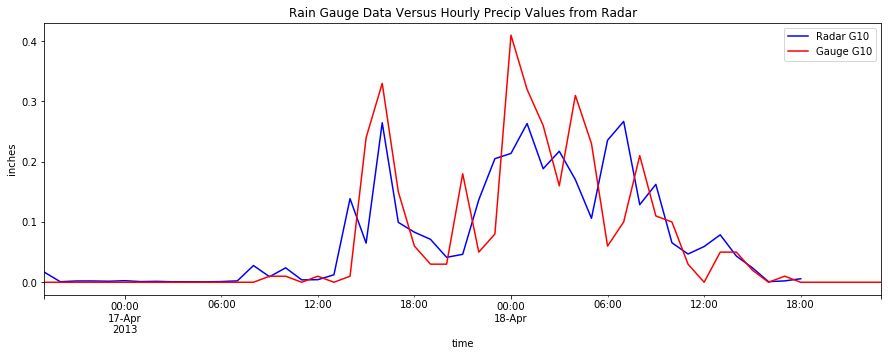

In [13]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)

plt.title("Rain Gauge Data Versus Hourly Precip Values from Radar")
plt.ylabel("inches")
df_new.plot(x='time', y="G10", label="Radar" + " G10", color='blue', ax=ax1)
hp_new.plot(x='time', y="G10", label="Gauge" + " G10", color='red', ax=ax1 )

These next few blocks of code create a new array, removing the 'time' column so that we can loop through both the datasets and plot them.

In [25]:
col1_names = list(df_new.columns.values)
col2_names = list(hp_new.columns.values)

In [26]:
common = np.intersect1d(col1_names, col2_names)

In [27]:
index = np.argwhere(common=='time')

In [28]:
col = np.delete(common, index)

Here is the looping code, which plots the individual gauge and radar-estimated rain rate data on one plot.

In [29]:
for i in col:
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(111)
    df_new.plot(x='time', y=i, label="Radar " + i, color='blue', ax=ax1, legend=True)
    hp_new.plot(x='time', y=i, label="Gauge " + i, color='red', ax=ax1, legend=True)
    plt.ylabel("inches")
    plt.title("Rain Gauge Totals Versus Rainfall-Estimated Rain Rate")
#    plt.savefig( '/home/amedendorp/Desktop/SAVUER/RadarVGauge/' + i)
#    plt.show()
    plt.close()

This next block of code plots  the data from all of the sites. One plots the rain rate, the other plots the rain gauge data. We need to include the extra argument in col2_names or else the code will be attempting to plot time versus time, which will result in an error.

<Figure size 1152x576 with 0 Axes>

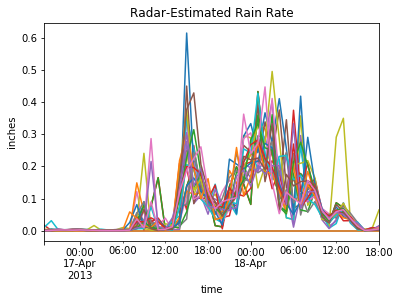

<Figure size 1152x576 with 0 Axes>

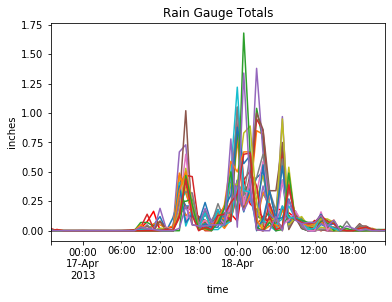

In [30]:
col_names = list(df_mean.columns.values)
col2_names = list(hp_new.columns.drop('time'))

fig = plt.figure(figsize=(16, 8))
ax = df_new.plot(x='time', y="G1", color='red')
for i in col_names:
    df_new.plot(x='time', y=i, ax=ax)
ax.get_legend().remove()
plt.ylabel("inches")
plt.title("Radar-Estimated Rain Rate")
#plt.savefig('/home/amedendorp/Desktop/SAVUER/RadarVGauge/Radar-Estimated_Rain_Rate', bbox_inches='tight')

fig2 = plt.figure(figsize=(16, 8))
ax = df_new.plot(x='time', y="G1", color='red')
for i in col2_names:
    hp_new.plot(x='time', y=i, ax=ax)
ax.get_legend().remove()
plt.ylabel("inches")
plt.title("Rain Gauge Totals")
#plt.savefig('/home/amedendorp/Desktop/SAVUER/RadarVGauge/Rain_gauge_Totals', bbox_inches='tight')

plt.show()

Next, plot both of the above plots together on the same figure:

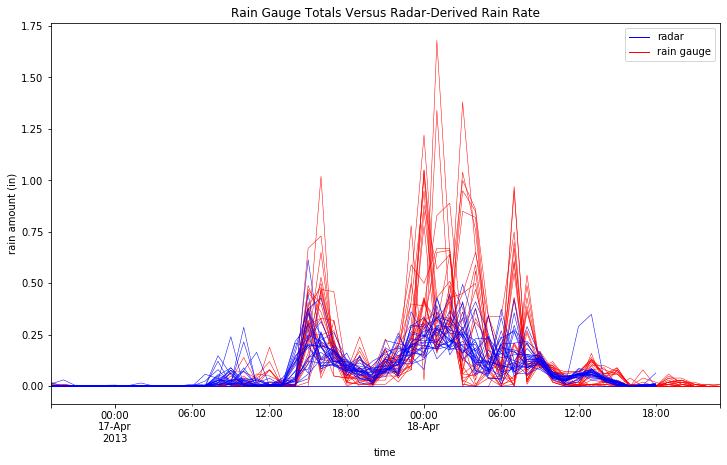

In [98]:
legend_elements = [Line2D([0], [0], color='blue', linewidth=1),
                   Line2D([0], [0], color='red', linewidth=1)]

fig, ax = plt.subplots(figsize=(12, 7))

for i in col2_names:
    hp_new.plot(x='time', y=i, ax=ax, color='red', label='radar', linewidth=.5)

for i in col_names:
    df_new.plot(x='time', y=i, ax=ax, color='blue', label='rain gauge', linewidth=.5)

ax.legend(legend_elements, ['radar', 'rain gauge'])
plt.ylabel("rain amount (in)")
plt.title("Rain Gauge Totals Versus Radar-Derived Rain Rate")
plt.savefig('/home/amedendorp/Desktop/SAVUER/RadarVGauge/Rain_gauge_V_Radar', bbox_inches='tight')

plt.show()

This next block of code plots the average of both the rain gauge data and the radar-derived rain rate

In [31]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

[]

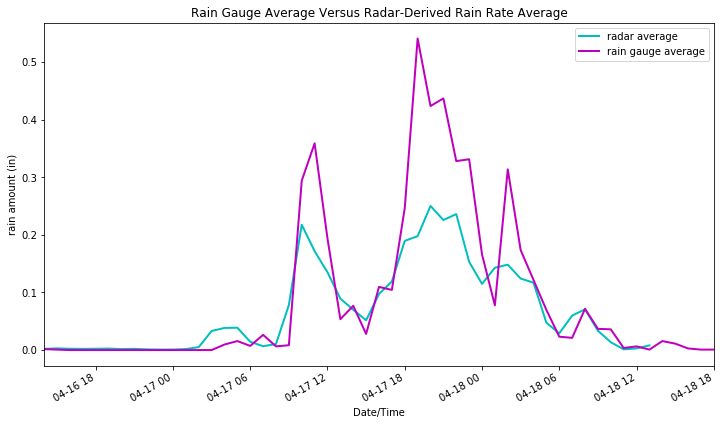

In [82]:
legend_elements = [Line2D([0], [0], color='c', linewidth=2),
                   Line2D([0], [0], color='m', linewidth=2)]

hp_mean=hp_new.mean(axis=1)
df_mean=df_new.mean(axis=1)


fig, ax = plt.subplots(figsize=(12, 7))

df_mean.plot(color='c', linewidth=2, ax=ax)
hp_mean.plot(color='m', linewidth=2, ax=ax)

ax.legend(legend_elements, ['radar average', 'rain gauge average'])
plt.ylabel("rain amount (in)")
plt.title("Rain Gauge Average Versus Radar-Derived Rain Rate Average")
plt.savefig('/home/amedendorp/Desktop/SAVUER/RadarVGauge/Rain_gauge_V_Radar_Avg', bbox_inches='tight')
plt.plot()

And now, combine the averages and the original lines on the same figure.

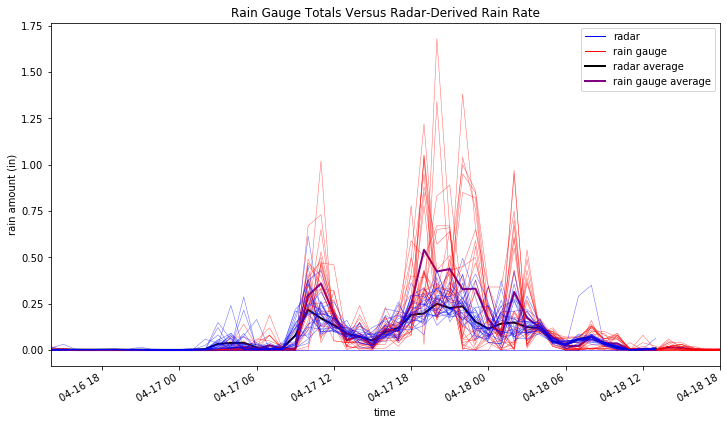

In [117]:
legend_elements = [Line2D([0], [0], color='blue', linewidth=1),
                   Line2D([0], [0], color='r', linewidth=1),
                   Line2D([0], [0], color='k', linewidth=2),
                   Line2D([0], [0], color='purple', linewidth=2)]

hp_mean=hp_new.mean(axis=1)
df_mean=df_new.mean(axis=1)

fig, ax = plt.subplots(figsize=(12, 7))

df_mean.plot(color='k', linewidth=2, ax=ax)
hp_mean.plot(color='purple', linewidth=2, ax=ax)
plt.plot()

for i in col2_names:
    hp_new.plot(x='time', y=i, ax=ax, color='red', label='radar', linewidth=.5, alpha=.6)

for i in col_names:
    df_new.plot(x='time', y=i, ax=ax, color='blue', label='rain gauge', linewidth=.5, alpha=.6)

ax.legend(legend_elements, ['radar', 'rain gauge', 'radar average', 'rain gauge average'])
plt.ylabel("rain amount (in)")
plt.title("Rain Gauge Totals Versus Radar-Derived Rain Rate")
plt.savefig('/home/amedendorp/Desktop/SAVUER/RadarVGauge/Rain_gauge_V_Radar_Final', bbox_inches='tight')

plt.show()